In [1]:
import json
import pandas as pd
from pathlib import Path
from pprint import pprint
import datetime
import time
import numpy as np
import matplotlib as plt

import pandas
import researchpy as rp
import seaborn as sns

import statsmodels.api as sm
from statsmodels.formula.api import ols
import statsmodels.stats.multicomp

%matplotlib inline

In [2]:
#path_results = Path('/media/discoD/models/elmo/ner/datalawyer')
path_results = Path('/opt/models/elmo/ner/results/')
#path_results = Path('/opt/models/elmo/ner/results_datalawyer_jur/')

In [3]:
for folder in path_results.iterdir():
    print(folder)

/opt/models/elmo/ner/results/datalawyer


In [4]:
configs = dict()
metrics = dict()
for folder in path_results.iterdir():
    if folder.is_dir():
        results_model_folder = folder.iterdir()
        for training_folder in results_model_folder:
            #print('Reading files from %s' % training_folder.name)
            has_metrics = False
            for results_file in training_folder.iterdir():
                if results_file.name.endswith('.json'):
                    #print('Parsing data from %s' % results_file.name)
                    if results_file.name.startswith('config'):
                        configs[training_folder.name] = json.loads(results_file.read_bytes())
                    elif results_file.name.startswith('metrics.'):
                        metrics[training_folder.name] = json.loads(results_file.read_bytes())
                        has_metrics = True
            if not has_metrics:
                print('metrics.json not found for %s' % training_folder.name)
                del configs[training_folder.name]
print(len(metrics))
print(len(configs))

metrics.json not found for datalawyer_word2vec-lc_skip_jur_5B-mc10_0_1
6
6


In [5]:
def get_seconds(time_str):
    x = time.strptime(time_str,'%H:%M:%S')
    return datetime.timedelta(hours=x.tm_hour,minutes=x.tm_min,seconds=x.tm_sec).total_seconds()
def get_average_epoch_duration(metrics):
    seconds = get_seconds(metrics['training_duration'])
    training_epochs = metrics['training_epochs'] + 1
    return seconds / training_epochs

In [6]:
TRAINING_ID = 'Training_ID'
SCENARIO = 'Scenario'
MODEL = 'Model'
EMBEDDING = 'Embedding'
EMBEDDING_TYPE = 'Embedding_Type'
DOMAN_SPECIFIC = 'Domain_Specific'
BATCH_SIZE = 'Batch_Size'
ELMO_DROPOUT = 'ELMo_Dropout'
TRAINING_NUMBER = 'Training_Number'
EXECUTION_NUMBER = 'Execution_Number'
BEST_EPOCH = 'Best_Epoch'
TRAINING_EPOCHS = 'Training_Epochs'
TRAINING_DURATION = 'Training_Duration'
TOTAL_DURATION = 'Total_Duration(s)'
AVERAGE_EPOCH_DURATION = 'Average_Epoch_Duration(s)'
TRAINING_ACCURACY = 'Training_Accuracy'
TRAINING_ACCURACY_TOP3 = 'Training_Accuracy_Top-3'
TRAINING_PRECISION = 'Training_Precision'
TRAINING_RECALL = 'Training_Recall'
TRAINING_F1_MEASURE = 'Training_F1-Measure'
TRAINING_LOSS = 'Training_Loss'
BEST_VALIDATION_ACCURACY = 'Best_Validation_Accuracy'
BEST_VALIDATION_ACCURACY_TOP3 = 'Best_Validation_Accuracy_Top-3'
BEST_VALIDATION_PRECISION = 'Best_Validation_Precision'
BEST_VALIDATION_RECALL = 'Best_Validation_Recall'
BEST_VALIDATION_F1_MEASURE = 'Best_Validation_F1-Measure'
BEST_VALIDATION_LOSS = 'Best_Validation_Loss'
TEST_ACCURACY = 'Test_Accuracy'
TEST_ACCURACY_TOP3 = 'Test_Accuracy_Top-3'
TEST_PRECISION = 'Test_Precision'
TEST_RECALL = 'Test_Recall'
TEST_F1_MEASURE = 'Test_F1_Measure'
TEST_LOSS = 'Test_Loss'
columns = [TRAINING_ID, MODEL, EMBEDDING, DOMAN_SPECIFIC, EMBEDDING_TYPE, TRAINING_NUMBER, EXECUTION_NUMBER, BEST_EPOCH, TRAINING_EPOCHS, TRAINING_DURATION, TOTAL_DURATION, AVERAGE_EPOCH_DURATION, TRAINING_ACCURACY, TRAINING_ACCURACY_TOP3, TRAINING_PRECISION, TRAINING_RECALL, TRAINING_F1_MEASURE, TRAINING_LOSS, BEST_VALIDATION_ACCURACY, BEST_VALIDATION_ACCURACY_TOP3, BEST_VALIDATION_PRECISION, BEST_VALIDATION_RECALL, BEST_VALIDATION_F1_MEASURE, BEST_VALIDATION_LOSS, TEST_ACCURACY, TEST_ACCURACY_TOP3, TEST_PRECISION, TEST_RECALL, TEST_F1_MEASURE, TEST_LOSS]
columns

['Training_ID',
 'Model',
 'Embedding',
 'Domain_Specific',
 'Embedding_Type',
 'Training_Number',
 'Execution_Number',
 'Best_Epoch',
 'Training_Epochs',
 'Training_Duration',
 'Total_Duration(s)',
 'Average_Epoch_Duration(s)',
 'Training_Accuracy',
 'Training_Accuracy_Top-3',
 'Training_Precision',
 'Training_Recall',
 'Training_F1-Measure',
 'Training_Loss',
 'Best_Validation_Accuracy',
 'Best_Validation_Accuracy_Top-3',
 'Best_Validation_Precision',
 'Best_Validation_Recall',
 'Best_Validation_F1-Measure',
 'Best_Validation_Loss',
 'Test_Accuracy',
 'Test_Accuracy_Top-3',
 'Test_Precision',
 'Test_Recall',
 'Test_F1_Measure',
 'Test_Loss']

In [7]:
def get_training_data_from_id(training_id, config):
    data = training_id.split('_')
    print(data)
    if len(data) == 4:
        return {MODEL: data[0], EMBEDDING: data[1], DOMAN_SPECIFIC: False, EMBEDDING_TYPE: 'No', TRAINING_NUMBER: data[2], EXECUTION_NUMBER: data[3]}
    elif len(data) == 5:
        embedding_type = 'No' if data[1] == 'glove-lc' else data[2]
        domain_specific = data[2] == 'jur'
        return {MODEL: data[0], EMBEDDING: data[1], DOMAN_SPECIFIC: domain_specific, EMBEDDING_TYPE: embedding_type, TRAINING_NUMBER: data[3], EXECUTION_NUMBER: data[4]}
    elif len(data) == 6:
        embedding_type = 'No' if data[1] == 'glove-lc' else data[3]
        domain_specific = data[2] == 'jur'
        embedding = data[1] + '-' + data[3] if data[1] == 'glove-lc' else data[1]
        return {MODEL: data[0], EMBEDDING: embedding, DOMAN_SPECIFIC: domain_specific, EMBEDDING_TYPE: embedding_type, TRAINING_NUMBER: data[4], EXECUTION_NUMBER: data[5]}
    elif len(data) == 7:
        return {MODEL: data[0], EMBEDDING: data[1] + '-' + data[4], DOMAN_SPECIFIC: True, EMBEDDING_TYPE: data[3], TRAINING_NUMBER: data[5], EXECUTION_NUMBER: data[6]}
    else:
        print('Invalid id: %s' % training_id)

In [8]:
training_data = []
for training_id, config in configs.items():
    training_metrics = metrics[training_id]
    data = get_training_data_from_id(training_id, config)
    data[TRAINING_ID] = training_id
    data[BEST_EPOCH] = training_metrics['best_epoch'] if training_metrics else None
    data[TRAINING_EPOCHS] = training_metrics['training_epochs'] + 1 if training_metrics else None
    data[TRAINING_DURATION] = training_metrics['training_duration'] if training_metrics else None
    data[TOTAL_DURATION] = get_seconds(training_metrics['training_duration']) if training_metrics else None
    data[AVERAGE_EPOCH_DURATION] = get_average_epoch_duration(training_metrics) if training_metrics else None
    data[TRAINING_ACCURACY] = training_metrics['training_accuracy'] if training_metrics else None
    data[TRAINING_ACCURACY_TOP3] = training_metrics['training_accuracy3'] if training_metrics else None
    data[TRAINING_PRECISION] = training_metrics['training_precision-overall'] if training_metrics else None
    data[TRAINING_RECALL] = training_metrics['training_recall-overall'] if training_metrics else None
    data[TRAINING_F1_MEASURE] = training_metrics['training_f1-measure-overall'] if training_metrics else None
    data[TRAINING_LOSS] = training_metrics['training_loss'] if training_metrics else None
    data[BEST_VALIDATION_ACCURACY] = training_metrics['best_validation_accuracy'] if training_metrics else None
    data[BEST_VALIDATION_ACCURACY_TOP3] = training_metrics['best_validation_accuracy3'] if training_metrics else None
    data[BEST_VALIDATION_PRECISION] = training_metrics['best_validation_precision-overall'] if training_metrics else None
    data[BEST_VALIDATION_RECALL] = training_metrics['best_validation_recall-overall'] if training_metrics else None
    data[BEST_VALIDATION_F1_MEASURE] = training_metrics['best_validation_f1-measure-overall'] if training_metrics else None
    data[BEST_VALIDATION_LOSS] = training_metrics['best_validation_loss'] if training_metrics else None
    data[TEST_ACCURACY] = training_metrics['test_accuracy'] if training_metrics else None
    data[TEST_ACCURACY_TOP3] = training_metrics['test_accuracy3'] if training_metrics else None
    data[TEST_PRECISION] = training_metrics['test_precision-overall'] if training_metrics else None
    data[TEST_RECALL] = training_metrics['test_recall-overall'] if training_metrics else None
    data[TEST_F1_MEASURE] = training_metrics['test_f1-measure-overall'] if training_metrics else None
    data[TEST_LOSS] = training_metrics['test_loss'] if training_metrics else None
    training_data.append(data)

['datalawyer', 'glove-lc', 'jur', '5B-mc10', '0', '0']
['datalawyer', 'glove-lc', 'jur', '5B-mc10', '0', '2']
['datalawyer', 'word2vec-lc', 'cbow', 'jur', '5B-mc10', '0', '1']
['datalawyer', 'glove-lc', 'jur', '5B-mc10', '0', '1']
['datalawyer', 'word2vec-lc', 'skip', 'jur', '5B-mc10', '0', '0']
['datalawyer', 'word2vec-lc', 'cbow', 'jur', '5B-mc10', '0', '0']


In [9]:
pd.set_option('display.max_columns', 1000)
training_data_df = pd.DataFrame(training_data, columns=columns)
training_data_df

,Training_ID,Model,Embedding,Domain_Specific,Embedding_Type,Training_Number,Execution_Number,Best_Epoch,Training_Epochs,Training_Duration,Total_Duration(s),Average_Epoch_Duration(s),Training_Accuracy,Training_Accuracy_Top-3,Training_Precision,Training_Recall,Training_F1-Measure,Training_Loss,Best_Validation_Accuracy,Best_Validation_Accuracy_Top-3,Best_Validation_Precision,Best_Validation_Recall,Best_Validation_F1-Measure,Best_Validation_Loss,Test_Accuracy,Test_Accuracy_Top-3,Test_Precision,Test_Recall,Test_F1_Measure,Test_Loss
0,datalawyer_glove-lc_jur_5B-mc10_0_0,datalawyer,glove-lc-5B-mc10,True,No,0,0,8,20,01:22:36,4956.0,247.8,0.995693,0.995897,0.950237,0.950857,0.950547,6.893538,0.987811,0.988107,0.879259,0.893825,0.886482,28.959243,0.987238,0.987749,0.852446,0.873824,0.863003,35.517847
1,datalawyer_glove-lc_jur_5B-mc10_0_2,datalawyer,glove-lc-5B-mc10,True,No,0,2,17,20,01:25:30,5130.0,256.5,0.995635,0.995827,0.949935,0.951020,0.950477,6.974377,0.987663,0.988033,0.883982,0.889307,0.886637,32.433017,0.985355,0.985936,0.841221,0.863636,0.852282,44.111798
2,datalawyer_word2vec-lc_cbow_jur_5B-mc10_0_1,datalawyer,word2vec-lc-5B-mc10,True,jur,0,1,14,20,01:25:22,5122.0,256.1,0.993576,0.993868,0.928887,0.927673,0.928280,10.025423,0.989162,0.989605,0.888218,0.885542,0.886878,26.610513,0.986288,0.986886,0.862960,0.863636,0.863298,36.712281
3,datalawyer_glove-lc_jur_5B-mc10_0_1,datalawyer,glove-lc-5B-mc10,True,No,0,1,11,20,01:25:00,5100.0,255.0,0.995774,0.995973,0.952272,0.951184,0.951728,6.902308,0.988089,0.988422,0.895817,0.887048,0.891411,29.103644,0.985513,0.986112,0.867194,0.859718,0.863440,40.549438
4,datalawyer_word2vec-lc_skip_jur_5B-mc10_0_0,datalawyer,word2vec-lc-5B-mc10,True,jur,0,0,11,20,01:27:16,5236.0,261.8,0.996427,0.996600,0.955407,0.954939,0.955173,6.234894,0.988644,0.989051,0.896104,0.883283,0.889647,30.692035,0.985003,0.985636,0.863816,0.855016,0.859393,41.265299
5,datalawyer_word2vec-lc_cbow_jur_5B-mc10_0_0,datalawyer,word2vec-lc-5B-mc10,True,jur,0,0,14,20,01:25:00,5100.0,255.0,0.993518,0.993829,0.926114,0.922939,0.924524,9.280686,0.988625,0.989106,0.886398,0.893072,0.889722,25.717168,0.986200,0.986780,0.857143,0.869906,0.863477,35.151747


In [10]:
training_data_df.to_csv('training_data_20_epochs_mestrado_datalawyer.csv', index=None)

In [11]:
str(datetime.timedelta(seconds=training_data_df[TOTAL_DURATION].mean()))

'1:25:07.333333'

In [12]:
training_data_df.groupby([EMBEDDING_TYPE]).describe()[TEST_F1_MEASURE].sort_values(by='mean', ascending=False)

,count,mean,std,min,25%,50%,75%,max
Embedding_Type,,,,,,,,
jur,3.0,0.862056,0.002308,0.859393,0.861346,0.863298,0.863388,0.863477
No,3.0,0.859575,0.006320,0.852282,0.857642,0.863003,0.863221,0.863440


In [13]:
training_data_df.groupby([EMBEDDING]).describe()[TEST_F1_MEASURE].sort_values(by='mean', ascending=False)

,count,mean,std,min,25%,50%,75%,max
Embedding,,,,,,,,
word2vec-lc-5B-mc10,3.0,0.862056,0.002308,0.859393,0.861346,0.863298,0.863388,0.863477
glove-lc-5B-mc10,3.0,0.859575,0.006320,0.852282,0.857642,0.863003,0.863221,0.863440


In [14]:
training_data_df.groupby([EMBEDDING, EMBEDDING_TYPE]).describe()[TEST_F1_MEASURE].sort_values(by='mean', ascending=False)

,,count,mean,std,min,25%,50%,75%,max
Embedding,Embedding_Type,,,,,,,,
word2vec-lc-5B-mc10,jur,3.0,0.862056,0.002308,0.859393,0.861346,0.863298,0.863388,0.863477
glove-lc-5B-mc10,No,3.0,0.859575,0.006320,0.852282,0.857642,0.863003,0.863221,0.863440


In [15]:
training_data_df.groupby([EMBEDDING, DOMAN_SPECIFIC]).describe()[TEST_F1_MEASURE].sort_values(by='mean', ascending=False)

,,count,mean,std,min,25%,50%,75%,max
Embedding,Domain_Specific,,,,,,,,
word2vec-lc-5B-mc10,True,3.0,0.862056,0.002308,0.859393,0.861346,0.863298,0.863388,0.863477
glove-lc-5B-mc10,True,3.0,0.859575,0.006320,0.852282,0.857642,0.863003,0.863221,0.863440


In [16]:
training_data_df.groupby([EMBEDDING, EMBEDDING_TYPE, DOMAN_SPECIFIC]).describe()[TEST_F1_MEASURE].sort_values(by='mean', ascending=False)

,,,count,mean,std,min,25%,50%,75%,max
Embedding,Embedding_Type,Domain_Specific,,,,,,,,
word2vec-lc-5B-mc10,jur,True,3.0,0.862056,0.002308,0.859393,0.861346,0.863298,0.863388,0.863477
glove-lc-5B-mc10,No,True,3.0,0.859575,0.006320,0.852282,0.857642,0.863003,0.863221,0.863440


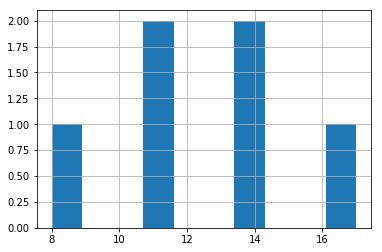

In [17]:
training_data_df[BEST_EPOCH].hist()

In [18]:
training_data_df[TOTAL_DURATION].describe()

count       6.000000
mean     5107.333333
std        89.770077
min      4956.000000
25%      5100.000000
50%      5111.000000
75%      5128.000000
max      5236.000000
Name: Total_Duration(s), dtype: float64

In [19]:
training_data_df.groupby([TRAINING_NUMBER]).describe()[TEST_F1_MEASURE].sort_values(by='mean', ascending=False)

,count,mean,std,min,25%,50%,75%,max
Training_Number,,,,,,,,
0,6.0,0.860815,0.004467,0.852282,0.860296,0.863151,0.863404,0.863477


In [20]:
rp.summary_cont(training_data_df[TEST_F1_MEASURE])

,Variable,N,Mean,SD,SE,95% Conf.,Interval
0,Test_F1_Measure,6.0,0.860815,0.004467,0.001824,0.856128,0.865503


In [21]:
rp.summary_cont(training_data_df.groupby(MODEL))[TEST_F1_MEASURE]

,N,Mean,SD,SE,95% Conf.,Interval
Model,,,,,,
datalawyer,6,0.860815,0.004467,0.001824,0.857241,0.86439


In [22]:
rp.summary_cont(training_data_df.groupby(EMBEDDING))[TEST_F1_MEASURE]

,N,Mean,SD,SE,95% Conf.,Interval
Embedding,,,,,,
glove-lc-5B-mc10,3,0.859575,0.006320,0.003649,0.852423,0.866726
word2vec-lc-5B-mc10,3,0.862056,0.002308,0.001332,0.859445,0.864668


In [23]:
rp.summary_cont(training_data_df.groupby([MODEL,EMBEDDING]))[TEST_F1_MEASURE]

N      Mean        SD        SE  95% Conf.  \
Model      Embedding                                                         
datalawyer glove-lc-5B-mc10     3  0.859575  0.006320  0.003649   0.852423   
           word2vec-lc-5B-mc10  3  0.862056  0.002308  0.001332   0.859445   

                                Interval  
Model      Embedding                      
datalawyer glove-lc-5B-mc10     0.866726  
           word2vec-lc-5B-mc10  0.864668

In [24]:
print(TEST_F1_MEASURE, MODEL, EMBEDDING, BATCH_SIZE, ELMO_DROPOUT)

Test_F1_Measure Model Embedding Batch_Size ELMo_Dropout


In [25]:
# Calculating effect size
def anova_table(aov):
    aov['mean_sq'] = aov[:]['sum_sq']/aov[:]['df']
    
    aov['eta_sq'] = aov[:-1]['sum_sq']/sum(aov['sum_sq'])
    
    aov['omega_sq'] = (aov[:-1]['sum_sq']-(aov[:-1]['df']*aov['mean_sq'][-1]))/(sum(aov['sum_sq'])+aov['mean_sq'][-1])
    
    cols = ['sum_sq', 'mean_sq', 'df', 'F', 'PR(>F)', 'eta_sq', 'omega_sq']
    aov = aov[cols]
    return aov

def print_anova(parameter):
    # Fits the model with the interaction term
    # This will also automatically include the main effects for each factor
    model = ols('Test_F1_Measure ~ C({0})'.format(parameter), training_data_df).fit()
    # Seeing if the overall model is significant
    print(f"Overall model F({model.df_model: .0f},{model.df_resid: .0f}) = {model.fvalue: .3f}, p = {model.f_pvalue: .20f}")
    print(model.summary())
    res = sm.stats.anova_lm(model, typ= 2)
    print(res)
    print(anova_table(res))
    mc = statsmodels.stats.multicomp.MultiComparison(training_data_df[TEST_F1_MEASURE], training_data_df[parameter])
    mc_results = mc.tukeyhsd()
    print(mc_results)

In [26]:
print_anova(EMBEDDING)

Overall model F( 1, 4) =  0.408, p =  0.55767539480897165838
                            OLS Regression Results                            
Dep. Variable:        Test_F1_Measure   R-squared:                       0.093
Model:                            OLS   Adj. R-squared:                 -0.134
Method:                 Least Squares   F-statistic:                    0.4081
Date:                Mon, 27 May 2019   Prob (F-statistic):              0.558
Time:                        23:37:34   Log-Likelihood:                 24.791
No. Observations:                   6   AIC:                            -45.58
Df Residuals:                       4   BIC:                            -46.00
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------

/home/user/anaconda3/envs/allennlp/lib/python3.6/site-packages/statsmodels/stats/stattools.py:72: ValueWarning: omni_normtest is not valid with less than 8 observations; 6 samples were given.
  "samples were given." % int(n), ValueWarning)
